In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
        
    def give_transition_matrix(self,melody):
        lookup = np.empty((5))
        lookup[[0,1,2,3,4]] = np.arange(5)
        counts = np.zeros((5,5))
        np.add.at(counts, (melody[:-1], melody[1:]),1 )
        probs = counts/counts.sum(axis=0, keepdims=True)
        self.transitions.append(probs)
        return probs
    

class Evaluator():
    def __init__(self):
        self.reward_history = []
        self.trajectories = []
        self.trajectories_eval = []
    def give_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
        
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01):
        self.n_actions = notes_to_choose
        self.states = notes_to_choose
        self.q = np.zeros((notes_to_choose, notes_to_choose))
        self.n = np.zeros((notes_to_choose, notes_to_choose))
        
        self.epsilon = ep
        self.gamma = gamma
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]
            

    def q_learn(self, ts):
        ### q-learn
        for interaction in ts:
            s, a, r, ns = interaction
            if ns != -1:
                self.n[s,a]+=1
                self.q[s,a] += (r+ self.gamma*np.max(self.q[ns,:]) - self.q[s,a])/self.n[s,a]
            else:
                self.n[s,a]+=1
                self.q[s,a] += (r- self.q[s,a])/self.n[s,a]
                
    def decrease_ep(self,ind):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/80), 0.01)
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player

In [2]:

def learn(melody):

    evaluator = Evaluator()
    agent = Agent(12, gamma=0., ep=0.5)
    episode_evaluate = list(range(31)) #[int(k) for k in np.logspace(0,4,10)]#np.logspace(0,4,10)#[0,1,3,5,10,50]#100,500]#list(range(10))#[0, 10, 50,100]

    for episode in tqdm(range(10**3)):
        ts=[]
        actions=[]
        for ind,note in enumerate(melody):
            action = agent.give_action(note)
            actions.append(action)
            reward = evaluator.give_reward(action,note)
            evaluator.reward_history.append(reward)
            if ind!=len(melody)-1:
                next_state = action
            else:
                next_state = -1
            ts.append([note, action, reward, next_state])


        agent.q_learn(ts)
        agent.decrease_ep(episode)
        #evaluator.trajectories.append(actions)

        if episode in episode_evaluate:
            evaluator.trajectories_eval.append(agent.give_melody(melody))
            evaluator.trajectories.append(actions)

    return evaluator, agent
            

In [3]:
melodies = [[0,4,7,4,0], [4,7,9,7,4], [7,9,11,9,7]]

In [4]:
evaluators =[]
for m in melodies:
    evaluators.append(learn(m))

100%|██████████| 1000/1000 [00:00<00:00, 2568.43it/s]


In [28]:
traj={}
for ind,ev in enumerate(evaluators):
    traj[ind] = ev.trajectories

In [12]:
evaluator = evaluators[0][0]

Text(0.5, 1.0, 'Learning curve')

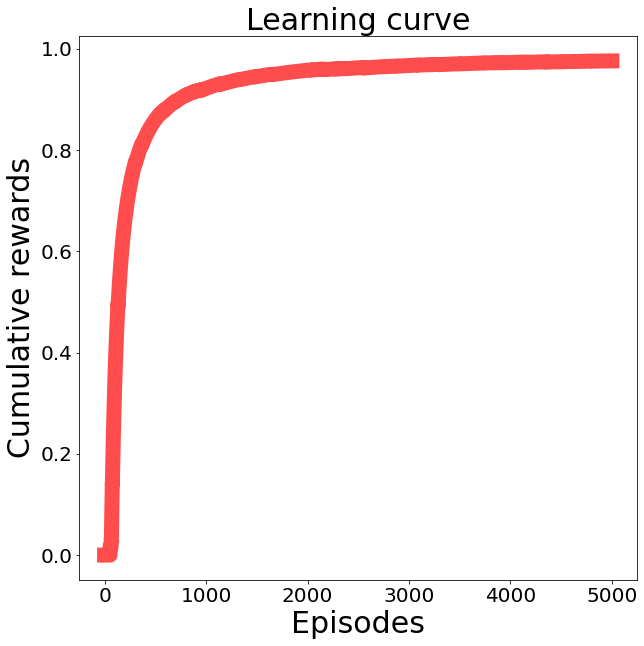

In [24]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=15, alpha=0.7,color="red")
plt.xlabel("Episodes",size=30)
plt.ylabel("Cumulative rewards", size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Learning curve", size=30)

In [29]:
traj[0]

[[2, 10, 2, 0, 1],
 [9, 3, 6, 6, 7],
 [8, 1, 6, 0, 8],
 [0, 7, 1, 5, 5],
 [0, 11, 2, 10, 0],
 [0, 7, 2, 2, 0],
 [0, 6, 3, 6, 0],
 [0, 3, 0, 1, 8],
 [6, 11, 2, 4, 0],
 [0, 4, 8, 4, 0],
 [0, 4, 5, 0, 0],
 [0, 4, 7, 8, 3],
 [11, 4, 3, 4, 0],
 [0, 9, 7, 0, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 8, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 2],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0],
 [0, 4, 7, 4, 0]]

In [7]:
traj[1]

[[0, 9, 2, 9, 6],
 [2, 0, 11, 5, 7],
 [9, 10, 5, 0, 2],
 [1, 9, 0, 10, 6],
 [5, 3, 9, 2, 8],
 [5, 11, 9, 7, 1],
 [7, 9, 4, 8, 5],
 [6, 7, 8, 7, 6],
 [3, 7, 9, 7, 4],
 [4, 11, 5, 6, 4],
 [1, 7, 6, 7, 8],
 [4, 7, 9, 1, 4],
 [4, 6, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 5, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4],
 [4, 7, 9, 7, 4]]

In [8]:
traj[2]

[[11, 11, 1, 7, 3],
 [9, 6, 7, 3, 11],
 [3, 10, 2, 2, 2],
 [0, 4, 1, 10, 10],
 [3, 7, 7, 11, 1],
 [2, 11, 4, 7, 8],
 [8, 2, 3, 5, 8],
 [5, 8, 8, 9, 1],
 [1, 9, 5, 9, 4],
 [2, 9, 1, 9, 8],
 [10, 9, 5, 9, 5],
 [9, 5, 5, 9, 4],
 [9, 9, 9, 9, 8],
 [5, 9, 5, 9, 9],
 [11, 9, 6, 9, 10],
 [4, 9, 2, 9, 0],
 [10, 9, 0, 9, 8],
 [8, 9, 6, 1, 3],
 [4, 9, 10, 9, 8],
 [6, 9, 3, 9, 9],
 [3, 9, 3, 9, 8],
 [0, 9, 10, 9, 0],
 [7, 9, 4, 9, 1],
 [7, 9, 0, 9, 7],
 [7, 9, 0, 9, 7],
 [7, 9, 2, 9, 7],
 [7, 9, 10, 9, 7],
 [7, 9, 2, 9, 7],
 [7, 9, 4, 9, 7],
 [7, 9, 6, 9, 7],
 [7, 9, 11, 9, 7]]

In [39]:
for agent in range(len(evaluators)):
    name="learning_ev{}".format(agent)
    os.makedirs(name, exist_ok=True)
    os.system("rm -r {}/*".format(name))

    for ind,p in enumerate(evaluators[agent].trajectories):
        lo=[list(np.array(p)+60), [int(k) for k in p]]
        np.savetxt("{}/episode_{}.csv".format(name,ind),lo, delimiter=",")
        
        #dd = pd.DataFrame.from_dict(dictionary, orient="index")
        #dd.to_csv("{}/episode_{}".format(name,ind), header=False)

In [26]:
N=12
points = [np.exp(2*np.pi*k*1j/N) for k in range(N)]

In [37]:
melody

[11, 1, 3, 5, 11]

In [41]:
import os

os.makedirs("figures", exist_ok=True)

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


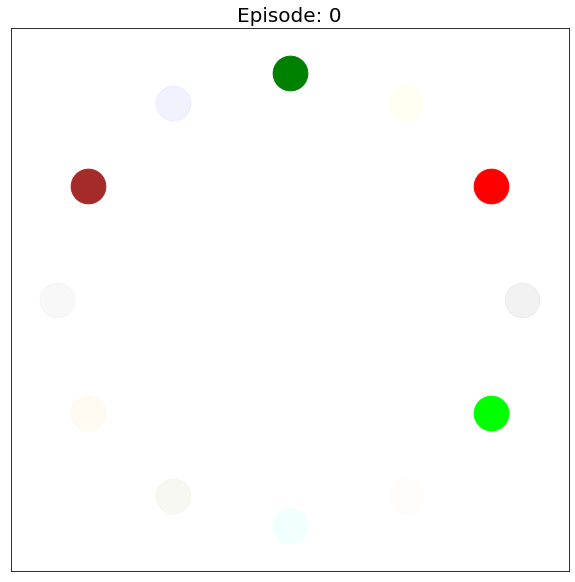

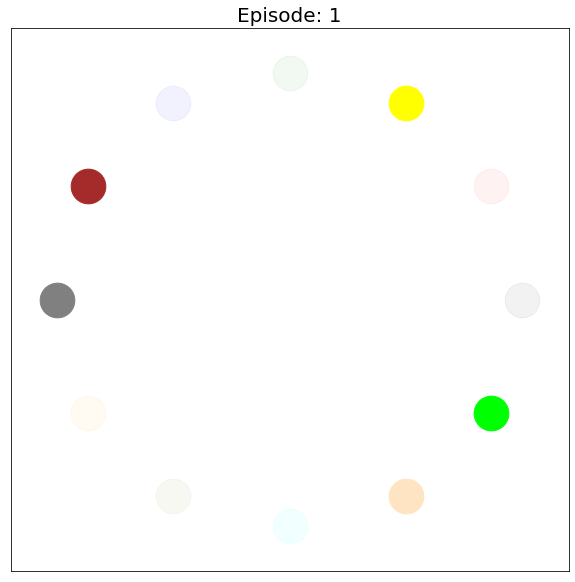

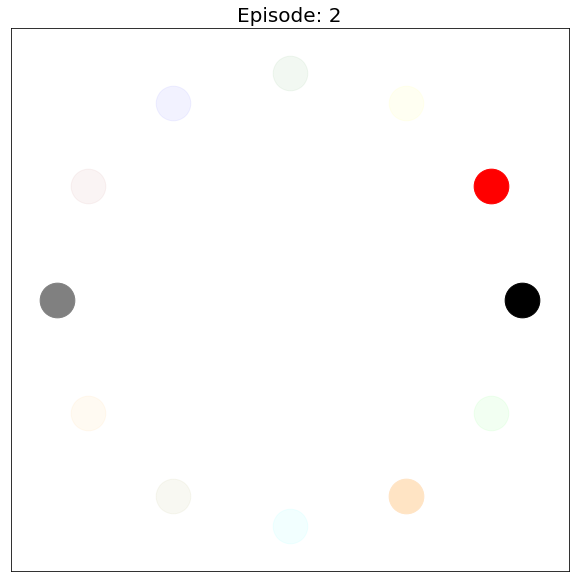

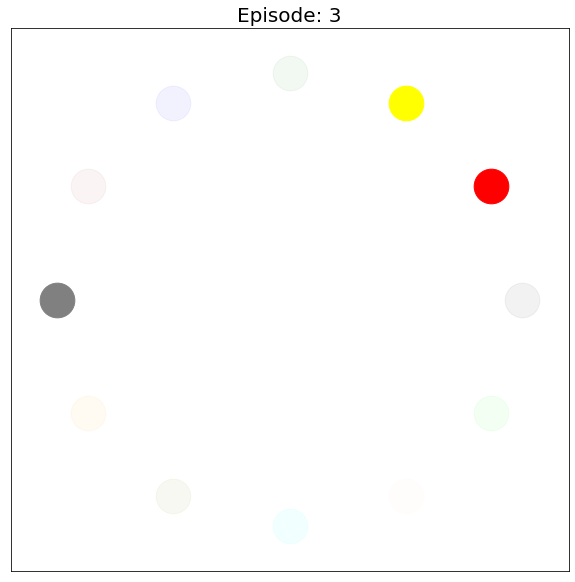

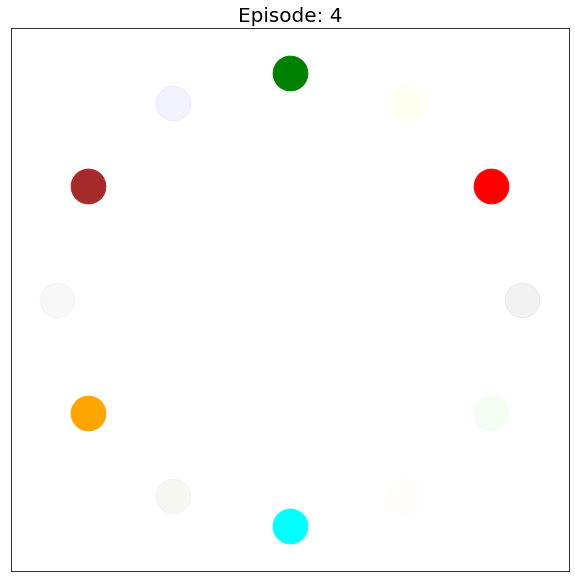

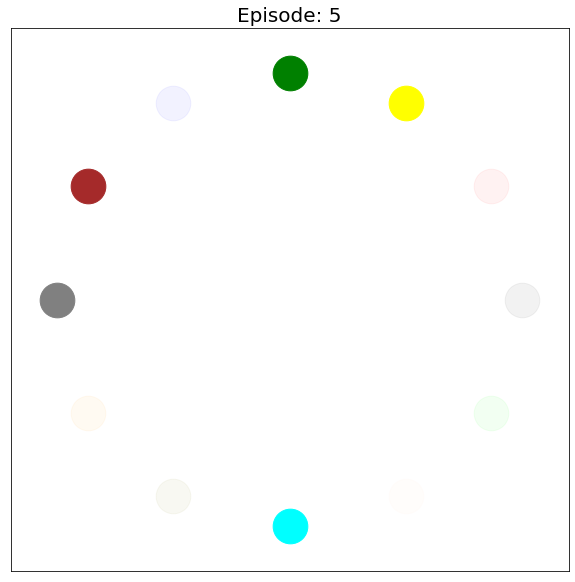

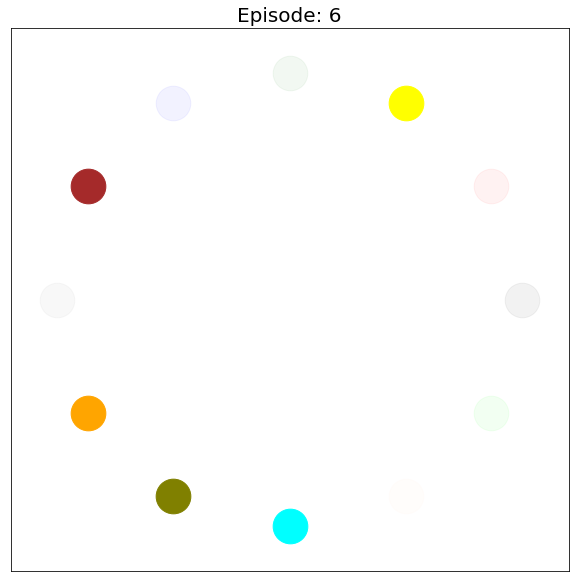

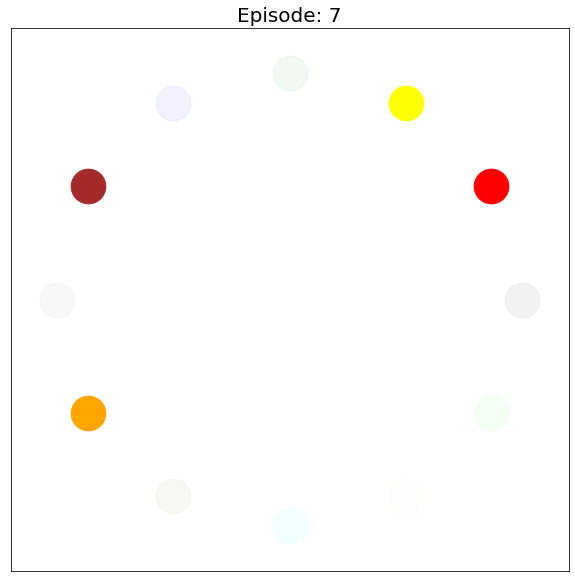

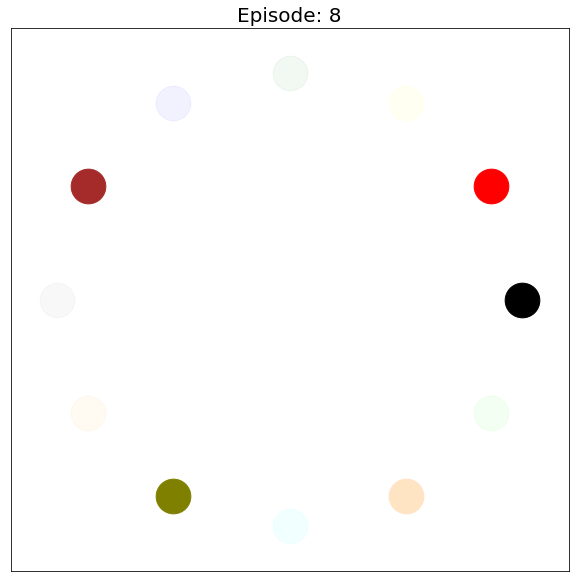

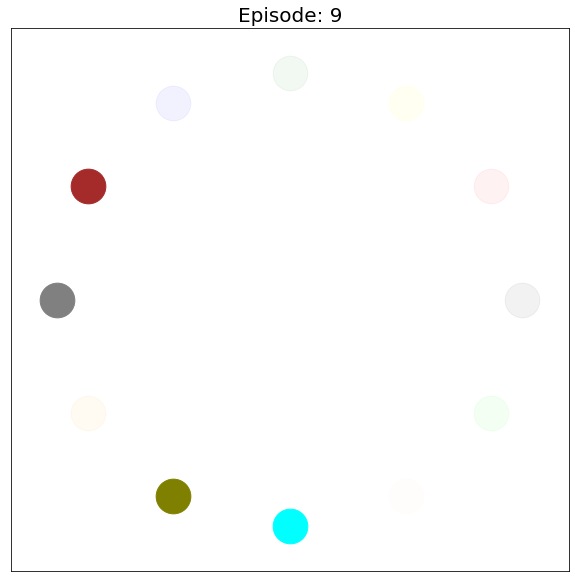

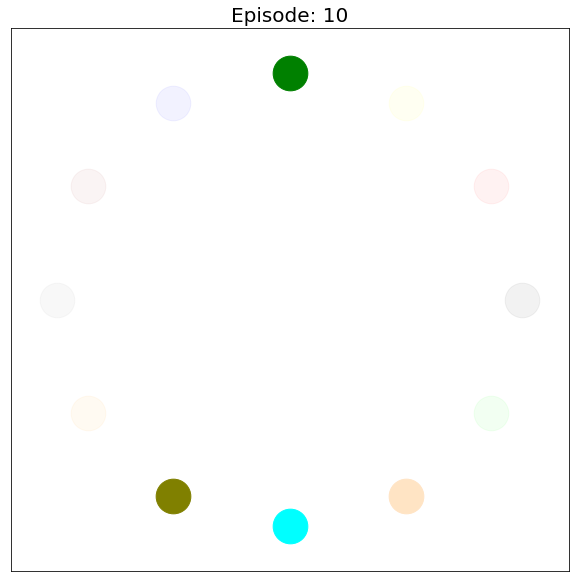

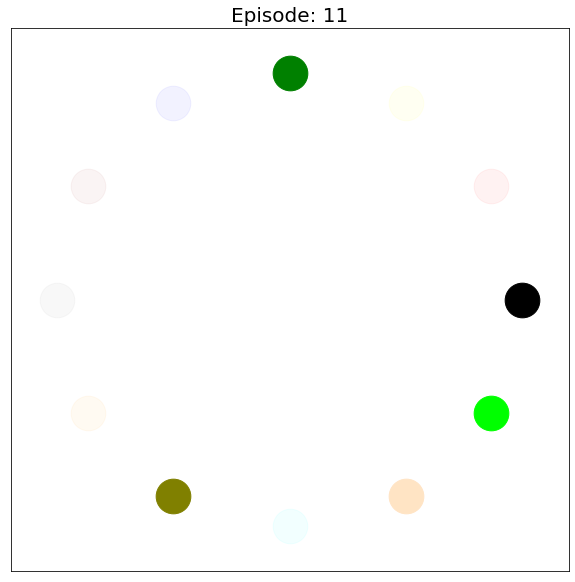

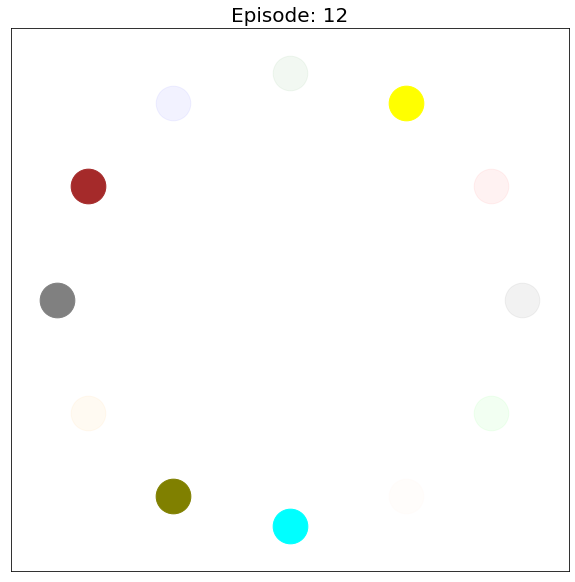

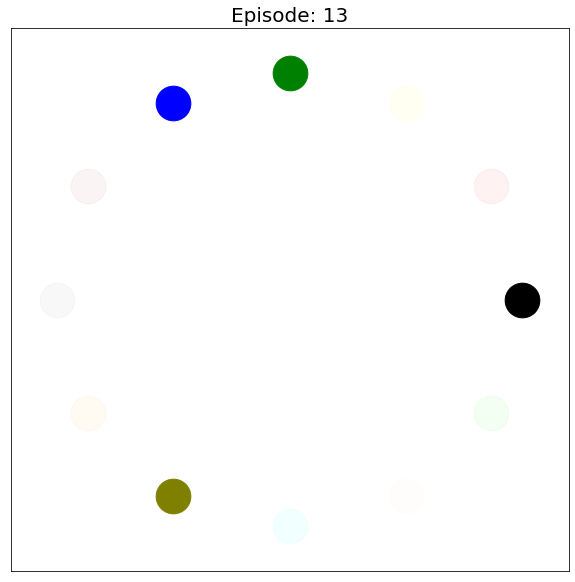

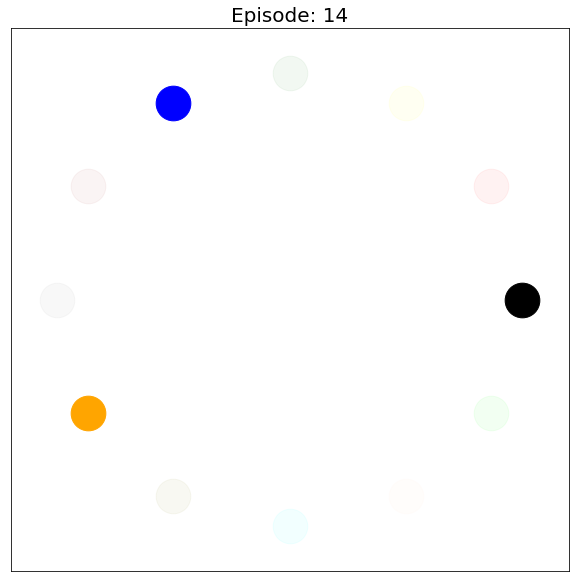

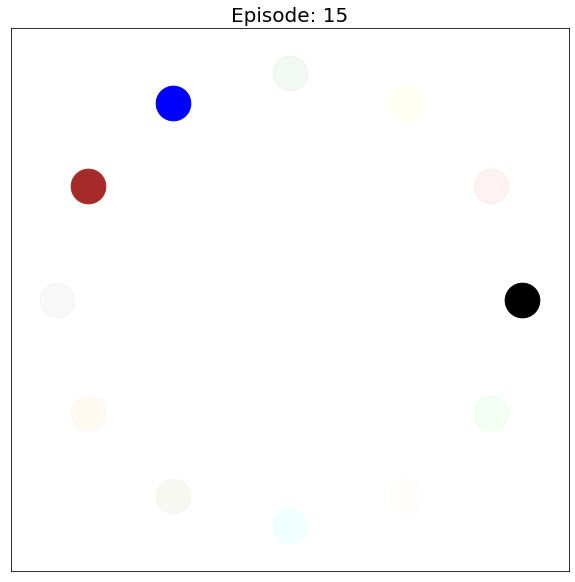

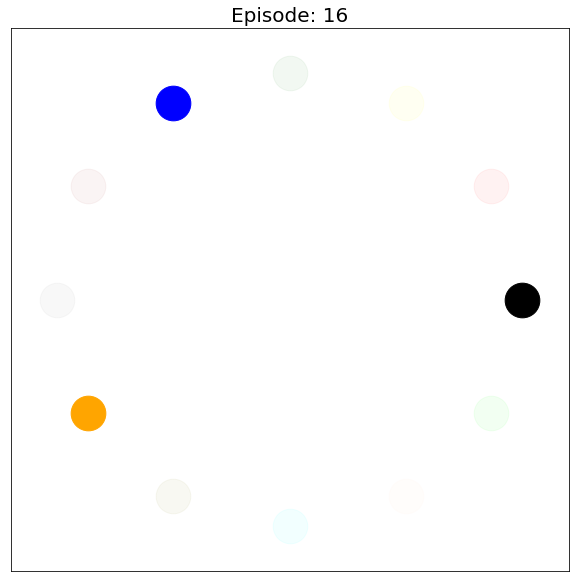

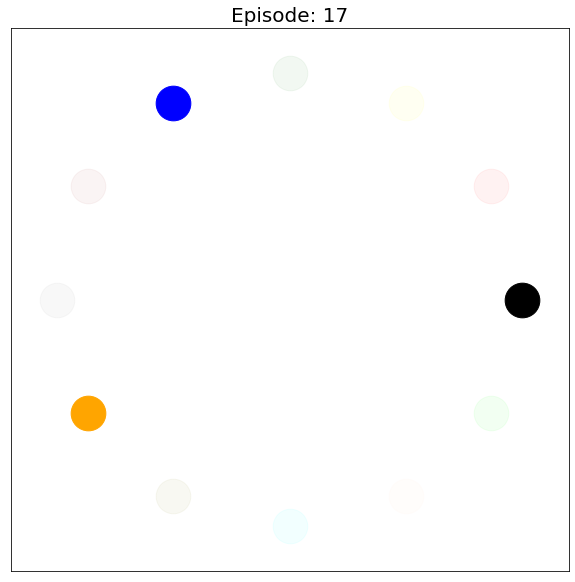

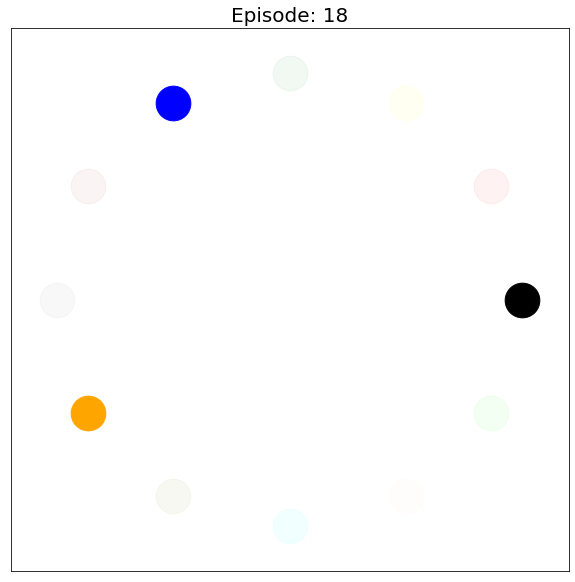

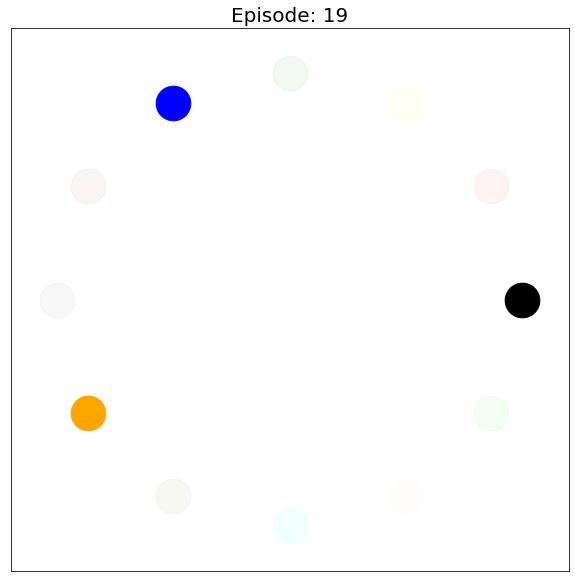

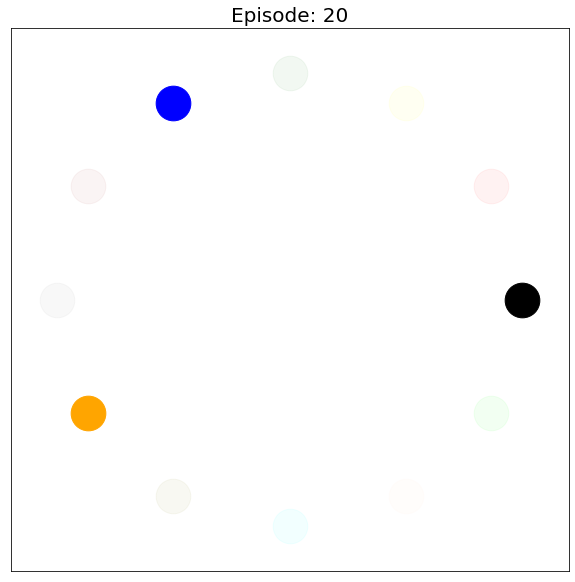

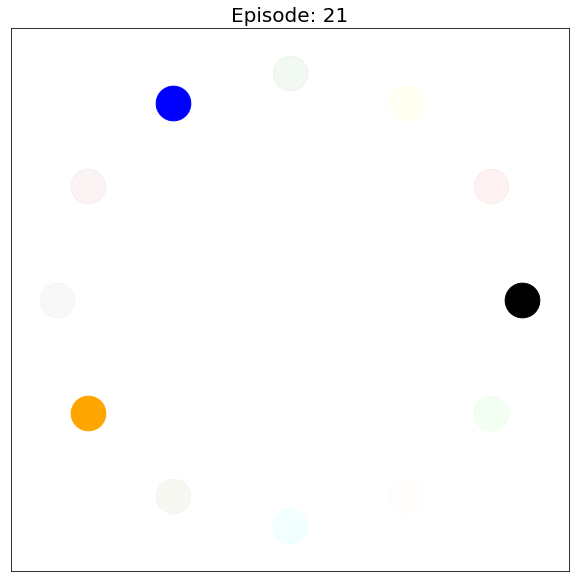

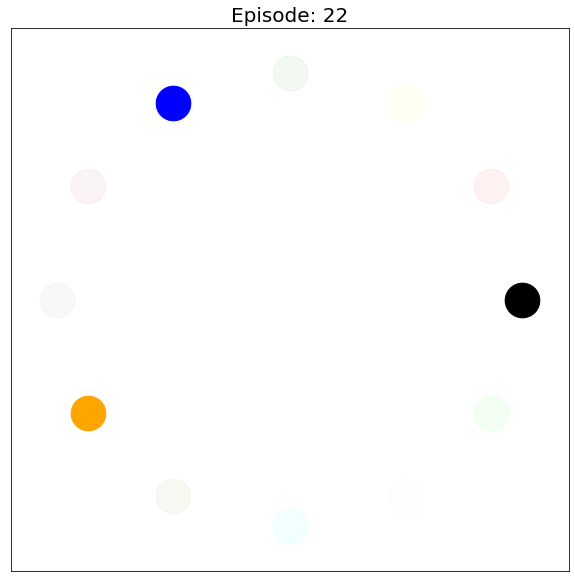

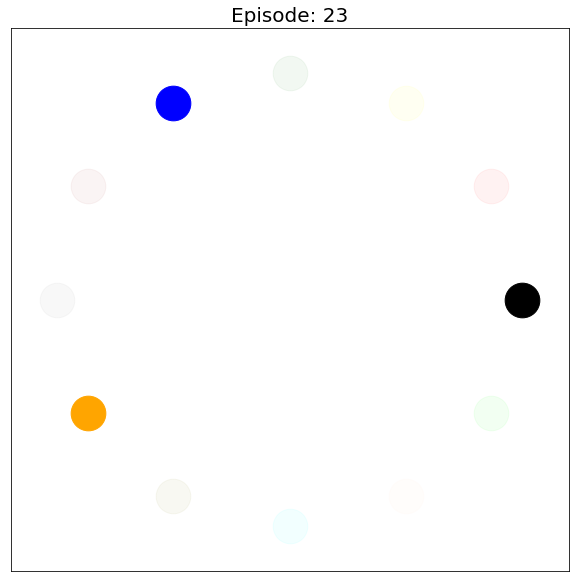

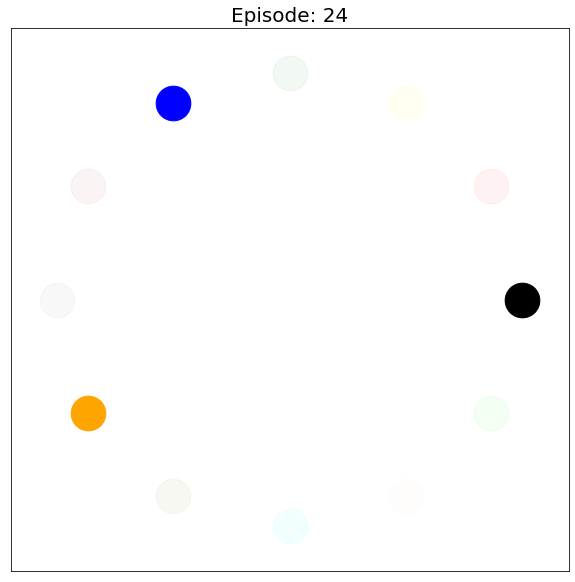

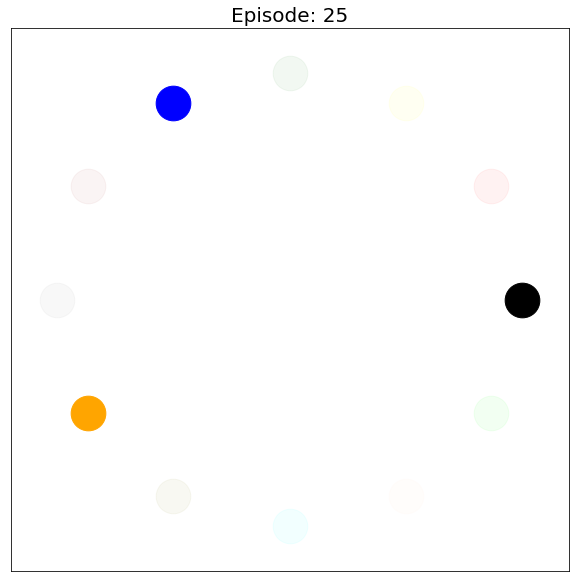

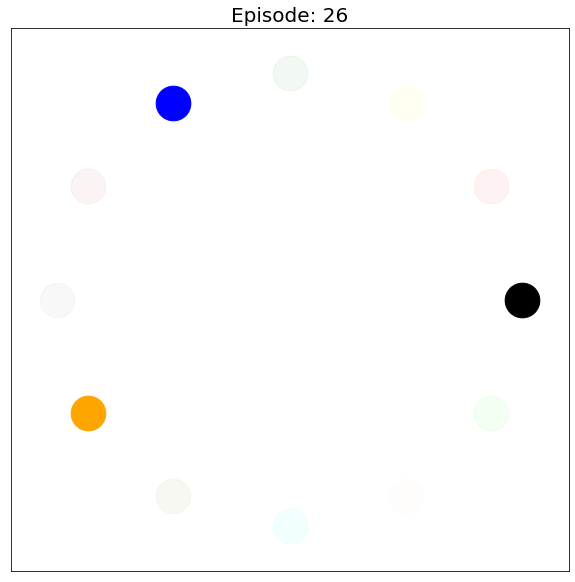

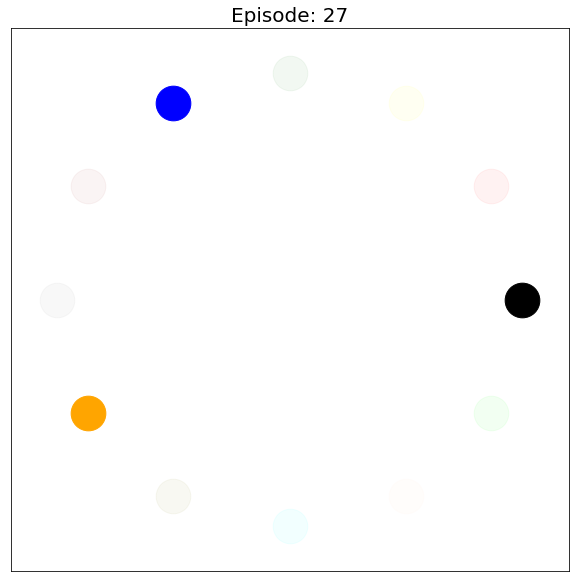

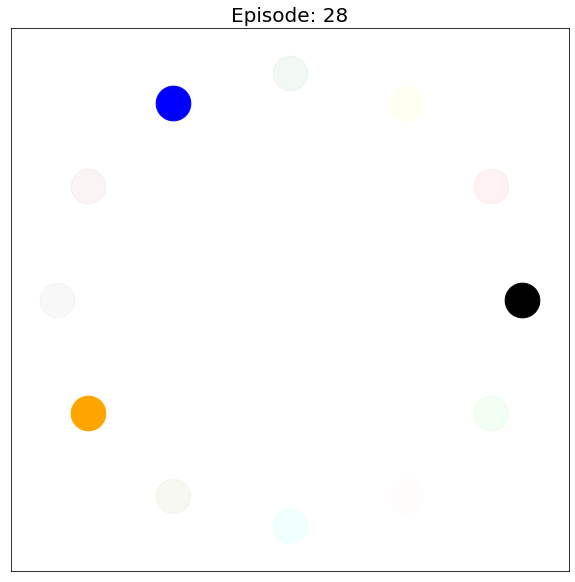

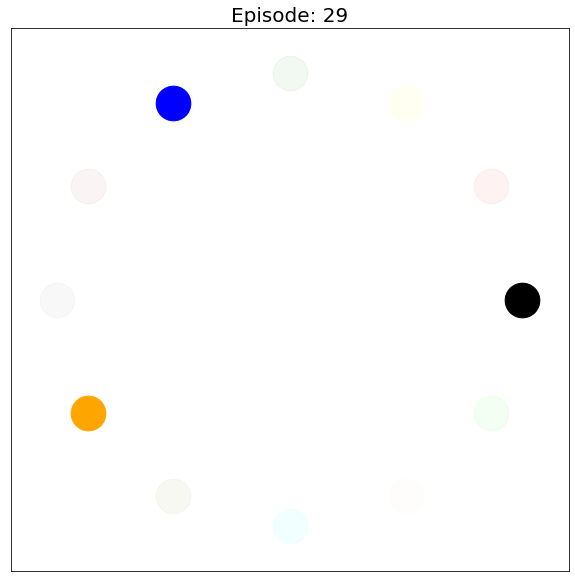

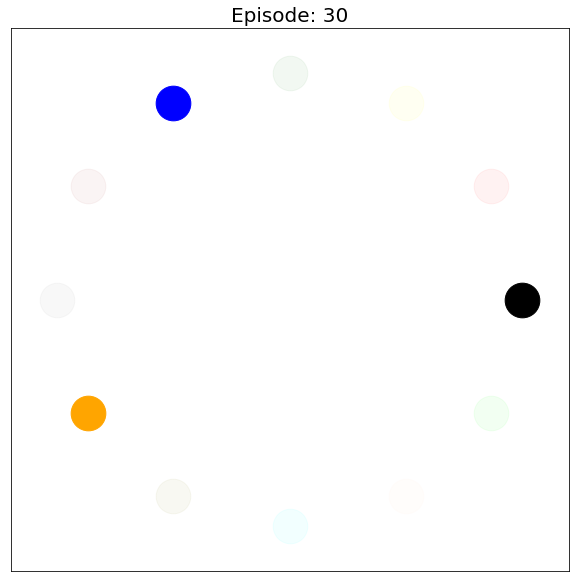

In [43]:
for ii,melody in enumerate(evaluator.trajectories):

    l=1.2
    size=1200
    plt.figure(figsize=(10,10))
    ax = plt.subplot2grid((1,1),(0,0))
    colors = ["black", "red", "yellow","green","blue","brown","grey","orange","olive","cyan","bisque", "lime","khaki"]
    for ind,p in enumerate(points):
        ax.scatter(*[p.real, p.imag], s=size, alpha=0.05, color=colors[ind])
        if ind in melody:
            ax.scatter(*[p.real, p.imag], s=size, alpha=1, color=colors[ind])

    ax.set_xlim([-l,l])
    ax.set_ylim([-l,l])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Episode: {}".format(ii),size=20)
    
    plt.savefig("figures/{}.png".format(ii))